Last time, I explored the relationship between Jeopardy answers that were U.S. states and their values and appearance by year. I didn't find much of a relationship. Here, I want to investigate whether the frequency of a state's appearance is related to its *popularity*. I'm going to use wikipedia article word counts and wikipedia views as a way of quantifying popularity.

Here's a reminder of the [Jeopardy data set](https://www.reddit.com/r/datasets/comments/1uyd0t/200000_jeopardy_questions_in_a_json_file/) 

File format:
> The json file is an unordered list of questions where each question has

>'category' : the question category, e.g. "HISTORY"

>'value' : Dollar value of the question as string, e.g. "$200"
Note: This is "None" for Final Jeopardy! and Tiebreaker questions

>'question' : text of question
Note: This sometimes contains hyperlinks and other things messy text such as when there's a picture or video question

>'answer' : text of answer

>'round' : one of "Jeopardy!","Double Jeopardy!","Final Jeopardy!" or "Tiebreaker"
Note: Tiebreaker questions do happen but they're very rare (like once every 20 years)

>'show_number' : string of show number, e.g '4680'

>'air_date' : the show air date in format YYYY-MM-DD

## Let's load in the data and limit the time period.

In [1]:
# This command allows plots to appear in the jupyter notebook.
%matplotlib inline   
import pandas as pd
pd.set_option('max_colwidth', 300)  # Show more text in dataframe.
# First import the pandas package and load the cleaned json file into a dataframe called df.
df = pd.read_json('JEOPARDY_QUESTIONS1_cleaned.json')
# Let's convert air_date to date/time, rather than a string.
df['air_date'] = pd.to_datetime(df['air_date'], yearfirst= True)
# Only consider data from well-sampled years.
df = df[(df['air_date']>='2004-01-01') & (df['air_date']<='2011-12-31')]

In [2]:
list_of_states = ['Alabama','Alaska','Arizona','Arkansas','California', 
                  'Colorado','Connecticut', 'Delaware', 'Florida','Georgia',
                  'Hawaii','Idaho','Illinois','Indiana', 'Iowa', 'Kansas',
                  'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
                  'Michigan','Minnesota','Mississippi', 'Missouri','Montana','Nebraska', 
                  'Nevada','New Hampshire', 'New Jersey','New Mexico', 'New York',
                  'North Carolina', 'North Dakota','Ohio','Oklahoma', 'Oregon',
                  'Pennsylvania', 'Rhode Island','South Carolina', 'South Dakota',
                  'Tennessee','Texas','Utah','Vermont', 'Virginia', 'Washington', 
                  'West Virginia', 'Wisconsin', 'Wyoming']

In [3]:
# Create new dataframe with only states as answers.
state_answers = df[df['answer'].isin(list_of_states)]
count_state_answers = state_answers.answer.value_counts()
state_data = pd.DataFrame(count_state_answers)
state_data.columns = ['total_count']
state_data.head()

,total_count
California,92
Florida,81
Alaska,75
Hawaii,74
Texas,73


## Wikipedia article word counts don't trace Jeopardy popularity.
In order to answer the question of why some states appear as Jeopardy answers more frequently than others I decided to use wikipedia as a proxy for popularity. I first tried looking into word counts on a state's wikipedia article. I was thinking that possibly state's that are more popular or more interesting will have longer articles written about them. Let's see what that shows.

To investigate wikipedia articles, I used a [python wrapper for the wikipedia API](https://wikipedia.readthedocs.io/en/latest/) using the command `pip install wikipedia` to install it.

In [4]:
import wikipedia
print wikipedia.search("California")

[u'California', u'California City, California', u'Baja California Peninsula', u'Northern California', u'Spanish missions in California', u'Governor of California', u'California Gold Rush', u'Outline of California', u'History of California', u'California English']


In [5]:
print wikipedia.summary("California")[0:150]

California (/ˌkælᵻˈfɔːrnjə, -ni.ə/ KAL-ə-FORN-yə, KAL-ə-FORN-ee-ə) is the most populous state in the United States and the third most extensive by are


In [6]:
print wikipedia.search("Georgia")

[u'Georgia', u'Georgia (country)', u'University of Georgia', u'President of Georgia', u'Kingdom of Georgia', u'History of Georgia (country)', u'Georgia (U.S. state)', u'Province of Georgia', u'Georgia Dome', u'Georgia Southern\u2013Georgia State rivalry']


In [7]:
# The following line gives an error because of ambiguity between 
# Georgia-the U.S. state, Georgia-the country, and others.
# print wikipedia.summary("Georgia")[0:150]

Georgia, Washington, New York will possibly an error. 
I used the [links to states on wikipedia](https://en.wikipedia.org/wiki/List_of_states_and_territories_of_the_United_States) to figure out which states could cause problems.
    

In [8]:
# Make a copy of the the original list of states and create a list `list_of_states_wiki` to use to search wikipedia.
list_of_states_wiki = list(list_of_states)
list_of_states_wiki.remove('Georgia')
list_of_states_wiki.append('Georgia (U.S. state)')
list_of_states_wiki.remove('New York')
list_of_states_wiki.append('New York (state)')
list_of_states_wiki.remove('Washington')
list_of_states_wiki.append('Washington (state)')

In [9]:
list_of_states_wiki.sort()
list_of_states_wiki[0:10]

['Alabama',
 'Alaska',
 'Arizona',
 'Arkansas',
 'California',
 'Colorado',
 'Connecticut',
 'Delaware',
 'Florida',
 'Georgia (U.S. state)']

In [10]:
# Grab all wikipedia state articles and count the number of words in the article. 
# Make sure the word "state" is in the summary.
state_summary = {}
state_word_count = {}
for state in list_of_states_wiki:
    summary = wikipedia.summary(state)[0:200]
    state_summary[state] = summary
    if 'state' not in summary: print "Check state:", state
    statepage = wikipedia.WikipediaPage(state)
    state_word_count[state] = len(statepage.content.split(' '))

Check state: Hawaii


In [11]:
# Something is wrong with Hawaii. 
print wikipedia.search("Hawaii")

[u'Hawaii', u'Hawaii County, Hawaii', u'Flag of Hawaii', u'Territory of Hawaii', u'Hawaii (island)', u'Outline of Hawaii', u'Kingdom of Hawaii', u'Sugar plantations in Hawaii', u'University of Hawaii', u'Native Hawaiians']


In [12]:
# Search seems fine. What about the summary and word count?
print state_summary['Hawaii']
print state_word_count['Hawaii']


1


In [13]:
# Let's check another state to make sure other states are working ok.
print state_summary['Arizona']
print state_word_count['Arizona']

Arizona (/ɛərᵻˈzoʊnə, ærᵻ-/) (Navajo: Hoozdo Hahoodzo [xòːztò xɑ̀xòːtsò]; O'odham: Alĭ ṣonak [ˡaɺi ˡʃonak]) is a state in the southwestern region of the United States. It is also part of the Western U
9386


Something is odd about Hawaii's wikipedia. I don't know enough about wikipedia formatting to figure this out. For now, I'll just enter Hawaii's word count by hand. 

In [14]:
state_word_count['Hawaii'] = 12878

In [15]:
# Change state names back to original to combine with the `state_data` dataframe.
state_word_count['Washington'] = state_word_count.pop("Washington (state)")
state_word_count['Georgia'] = state_word_count.pop("Georgia (U.S. state)")
state_word_count['New York'] = state_word_count.pop("New York (state)")

In [16]:
# Create new dataframe to combine with `state_data` dataframe.
df_state_word_count = pd.DataFrame.from_dict(state_word_count, orient = 'index', dtype = float)
df_state_word_count.columns = ['wiki_word_count']
# Combine word counts to `state_data` dataframe.
state_data = state_data.join(df_state_word_count, how = 'outer')

Let's plot the number of words in a wikipedia article and the number of times a state has appeared on Jeopardy to see if there's a relationship.

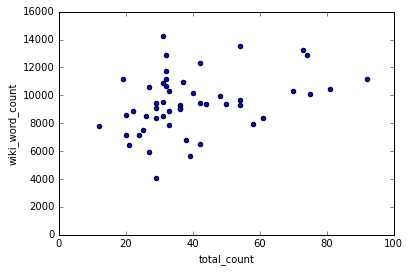

In [17]:
state_data.plot(x = 'total_count', y = 'wiki_word_count', kind = 'scatter', ylim= (0, 16000));

Hmmm... This is not as useful as I'd like it to be.  Low wikipedia word count articles seem to go with a low likelihood of appearing on Jeopardy. However, if an article has many words, it's difficult to determine how likely it is to appear on Jeopardy. In summary, don't study states with a low wikipedia article word count. 

## Wikipedia page views is a good tracer of Jeopardy popularity.
Rather than wikipedia word count, perhaps an alternative indicator of popularity is *wikipedia page views*. Luckily there is [another python tool which uses wikipedia's API to get page views](https://github.com/mediawiki-utilities/python-mwviews
). To install it, use `pip install mwviews`

In [18]:
# Import the wikipedia tool
from mwviews.api import PageviewsClient
p = PageviewsClient()

In [19]:
# Here's a fun command that let's you track the current trends on wikipedia.
# If you leave off year, month, and day, the returned result will be for `today`.
p.top_articles('en.wikipedia', year = 2017, month = 03, day = 19, limit=10)

[{u'article': u'Main_Page', u'rank': 1, u'views': 22740466},
 {u'article': u'Special:Search', u'rank': 2, u'views': 2196670},
 {u'article': u'Chuck_Berry', u'rank': 3, u'views': 912869},
 {u'article': u'Special:Book', u'rank': 4, u'views': 365141},
 {u'article': u'Iron_Fist_(comics)', u'rank': 5, u'views': 343979},
 {u'article': u'Yogi_Adityanath', u'rank': 6, u'views': 329172},
 {u'article': u'Iron_Fist_(TV_series)', u'rank': 7, u'views': 299507},
 {u'article': u'Beauty_and_the_Beast_(2017_film)',
  u'rank': 8,
  u'views': 282150},
 {u'article': u'More_Life', u'rank': 9, u'views': 241612},
 {u'article': u'Hans_Oster', u'rank': 10, u'views': 194937}]

Since I found in my previous post that the distribution of state appearances doesn't seem to vary much from year to year, I'll use the most recent year, 2016, to look at the page views on wikipedia over the course of a year.

In [20]:
# Here are the results for Arizona for 2016. 
p.article_views('en.wikipedia', ['Arizona'], 
                granularity='monthly', start='2016010100', end='2016123100')

{datetime.datetime(2016, 1, 1, 0, 0): {'Arizona': 131409},
 datetime.datetime(2016, 2, 1, 0, 0): {'Arizona': 125917},
 datetime.datetime(2016, 3, 1, 0, 0): {'Arizona': 151741},
 datetime.datetime(2016, 4, 1, 0, 0): {'Arizona': 174710},
 datetime.datetime(2016, 5, 1, 0, 0): {'Arizona': 123279},
 datetime.datetime(2016, 6, 1, 0, 0): {'Arizona': 112169},
 datetime.datetime(2016, 7, 1, 0, 0): {'Arizona': 101361},
 datetime.datetime(2016, 8, 1, 0, 0): {'Arizona': 106251},
 datetime.datetime(2016, 9, 1, 0, 0): {'Arizona': 112453},
 datetime.datetime(2016, 10, 1, 0, 0): {'Arizona': 120101},
 datetime.datetime(2016, 11, 1, 0, 0): {'Arizona': 137877},
 datetime.datetime(2016, 12, 1, 0, 0): {'Arizona': 114489}}

In [21]:
# The wikipedia tool doesn't automatically calculate page views annually. 
# Instead I'll just sum up the data for each month to get the results for a year.
state_views = {}
for state in list_of_states_wiki:
    views = p.article_views('en.wikipedia', [state], 
                        granularity='monthly', start='2016010100', end='2016123100')
    total_views = 0
    for view in views:
        key_state_name = views[view].keys()
        total_views +=views[view][key_state_name[0]]
    state_views[state] = total_views

In [22]:
# Combine new state view data into state_data dataframe.
state_views['Washington'] = state_views.pop("Washington (state)")
state_views['Georgia'] = state_views.pop("Georgia (U.S. state)")
state_views['New York'] = state_views.pop("New York (state)")
df_state_views = pd.DataFrame.from_dict(state_views, orient = 'index', dtype = float)
df_state_views.columns = ['wiki_views']
state_data = state_data.join(df_state_views, how = 'outer')

In [23]:
state_data.head()

,total_count,wiki_word_count,wiki_views
Alabama,32,11158.0,1340664.0
Alaska,75,10073.0,2631738.0
Arizona,44,9386.0,1511757.0
Arkansas,20,8570.0,1050623.0
California,92,11159.0,4985559.0


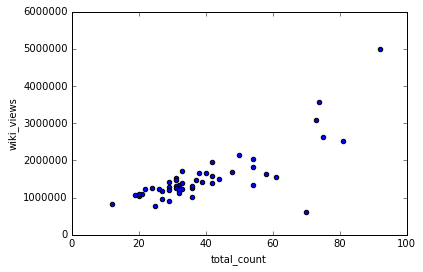

In [24]:
state_data.plot(x = 'total_count', y = 'wiki_views', kind = 'scatter');

Oooooh!  Look at that trend! Popular states on wikipedia searches are also popular states on Jeopardy!

In [41]:
# Check with with the a correlation matrix as well.
state_data.ix[:,state_data.columns].corr()

,total_count,wiki_word_count,wiki_views
total_count,1.000000,0.358394,0.821448
wiki_word_count,0.358394,1.000000,0.350184
wiki_views,0.821448,0.350184,1.000000


Looks good. Remember that the closer the number is to +1, the more positively correlated the two variables are.

However, looking back at the plot, there is an odd outlier. Let's take a look at that next.

## New York City or New York State?

What is that odd outlier located at `total_count` of about 70 and `wiki_views` under 1,000,000? It looks like its `total_count` value should be at least 30, or 40 less than it currently is.

In [25]:
# What is that outlier with total_count > 60, but wiki_views <1,000,000
state_data[(state_data['total_count']>60) & (state_data['wiki_views']<1000000)]

,total_count,wiki_word_count,wiki_views
New York,70,10338.0,613533.0


Hmmm.... that's odd. I wonder if the fact that "New York" can sometimes refer to the city or the state is the reason it is an outlier.  (The proper name for the city is ["City of New York"](https://en.wikipedia.org/wiki/New_York_City).) Let's see if Jeopardy sometimes uses an answer of "New York" when asking about the city. Are there around 40 of these questions where the answer is really about the city of New York?

In [26]:
# Find answers that are "New York" when the question contains the word "city."
df[(df['answer']=='New York') & (df['question'].str.contains('city'))]

,air_date,answer,category,question,round,show_number,value
10777,2008-04-08,New York,A HOST OF GHOSTS,The ghost of impresario David Belasco is said to haunt the theatre named for him on West 44th St. in this city,Jeopardy!,5437,400.0
130911,2005-05-11,New York,PRESIDENTS,"In April 1789 Washington left Mount Vernon, going to this city to head the new governent",Jeopardy!,4773,200.0
148356,2010-04-27,New York,ZOMBIELAND,"& they thought alligators were bad! In 1984's ""C.H.U.D."" zombies haunt this city's sewer system",Jeopardy!,5907,400.0
150545,2008-12-04,New York,STREETCAR,"Beginning service in 1832, this city's first streetcar ran along Bowery Street",Jeopardy!,5579,600.0
161170,2006-07-03,New York,THE U.S. CENSUS,"This city has the largest Hispanic, Asian & African-American populations in the U.S.",Double Jeopardy!,5036,400.0
204556,2011-10-20,New York,ACTING HURT,"John Hurt reprised the role of Quentin Crisp for 2009's ""An Englishman in"" this U.S. city",Double Jeopardy!,6229,1600.0
207097,2011-12-28,New York,UNCOMMON BONDS,"J. Max Bond Jr., who helped design the National September 11 Memorial, was a 1980-86 member of this city's Planning Commission",Jeopardy!,6278,200.0
208353,2006-11-15,New York,AROUND THE U.S.A.,"""I love"" this city, America's biggest metropolis--doesn't everyone?",Jeopardy!,5103,400.0
42784,2010-03-29,New York,MIDDLE INITIAL V.,"John V. Lindsay was mayor of this city in the turbulent '60s & '70s, first as a Republican & then as a Democrat",Jeopardy!,5886,200.0
45134,2011-06-01,New York,HAY IS,"...The middle name of Jock Whitney, millionaire art collector & publisher of this city's Herald Tribune",Double Jeopardy!,6163,400.0


In [27]:
# Aha! So some New York city answers did sneak into my state-only dataframe. How many?
df[(df['answer']=='New York') & (df['question'].str.contains('city'))]['question'].count()

12

I'm not sure that's enough. I need about 28 more to reach my goal of 40 extra questions.

Let's take a look in detail at some of the New York questions. Which questions have "New York" as the answer but don't mention "city" or "state" in the question?

In [28]:
# Find questions where "New York" is the answer, but "city" or "state" don't appear in the question.
df[(df['answer']=='New York') & (df['question'].str.contains('city')==False) 
   & (df['question'].str.contains('state')==False)]

,air_date,answer,category,question,round,show_number,value
102164,2004-04-16,New York,QUARTER BACKS,A gift from France unveiled in 1886,Jeopardy!,4525,400.0
11265,2005-01-26,New York,STATE THE COLLEGE TEAM,"Black Knights,Orangemen",Jeopardy!,4698,800.0
121918,2011-06-09,New York,STATE SONGS?,"Billy Joel: ""____ State Of Mind""",Jeopardy!,6169,400.0
123189,2009-05-27,New York,STATES' GEOGRAPHIC CENTERS,12 miles south of Oneida & 26 miles southwest of Utica,Jeopardy!,5703,800.0
126630,2009-02-20,New York,HOME BOYS,Knickerbockers,Double Jeopardy!,5635,800.0
131466,2006-04-04,New York,GEOGRAPHIC CINEMA,"1931:""Sidewalks of ___""",Jeopardy!,4972,800.0
139200,2011-02-23,New York,THE 13 COLONIES,"Under the Treaty of Breda, the Dutch gave up New Netherland to the British, who renamed it this in 1664",Double Jeopardy!,6093,400.0
141264,2004-04-29,New York,STATE MOTTOES,"""Excelsior"" (""Ever Upward"")",Jeopardy!,4534,800.0
146113,2006-03-28,New York,GODZILLA,"Apparently bored with his old conquests, in the 1998 version, Godzilla is intent on destroying this metropolis",Double Jeopardy!,4967,800.0
147556,2011-03-03,New York,TV CITY SETTINGS,"""Castle""",Double Jeopardy!,6099,1600.0


In [71]:
# How many of these are there?
df[(df['answer']=='New York') & (df['question'].str.contains('city')==False) 
   & (df['question'].str.contains('state')==False)]['question'].count()

32

A few questions jump out at me as referring to New York city rather than New York state. 

In [62]:
df[(df['answer']=='New York') & (df['question'].str.contains('Godzilla'))]

,air_date,answer,category,question,round,show_number,value
146113,2006-03-28,New York,GODZILLA,"Apparently bored with his old conquests, in the 1998 version, Godzilla is intent on destroying this metropolis",Double Jeopardy!,4967,800.0


In [63]:
df[(df['answer']=='New York') & (df['question'].str.contains('Castle'))]

,air_date,answer,category,question,round,show_number,value
147556,2011-03-03,New York,TV CITY SETTINGS,"""Castle""",Double Jeopardy!,6099,1600.0


In [66]:
df[(df['answer']=='New York') & (df['question'].str.contains("New Amsterdam"))]

,air_date,answer,category,question,round,show_number,value
15213,2008-02-27,New York,EARLY AMERICA,The British took New Netherland & New Amsterdam from the Dutch in 1664 & renamed them both this,Jeopardy!,5408,200.0
46877,2009-05-12,New York,CITIES' NEWER NAMES,New Amsterdam,Jeopardy!,5692,600.0


In [64]:
df[(df['answer']=='New York') & (df['question'].str.contains('Lights'))]

,air_date,answer,category,question,round,show_number,value
203523,2011-11-28,New York,A TALE OF ONE CITY,"Jay McInerney's ""Bright Lights, Big City""",Double Jeopardy!,6256,800.0


That only comes to about 5 more questions. 

So far we've looked at questions where the answer is "New York" and the questions either
* contains "city"
or
* does not contain "city" and does not contain "state".

Maybe there are some questions that mention "state" in the question, but are really asking about the city. That would seem odd. Let's check a few.



In [73]:
# Find questions where "New York" is the answer and "state" appears in the question.
df[(df['answer']=='New York') & (df['question'].str.contains('state'))]

,air_date,answer,category,question,round,show_number,value
103063,2005-12-26,New York,STATE OF THE UNION,Numerous Revolutionary War battles were fought in this state,Jeopardy!,4901,600.0
10846,2005-05-02,New York,STATE FIRSTS,In 2001 it became the first U.S. state to ban hand-held phone use while driving,Jeopardy!,4766,800.0
113096,2008-10-29,New York,2008,"Though not elected to the position, a man from this state became the 1st blind governor & the 4th black governor in the U.S.",Final Jeopardy!,5553,NaN
122754,2007-04-12,New York,GOVERNORS,"Of the 17 state governors who became president, the most from any state, 4, were from this one",Final Jeopardy!,5209,NaN
1308,2006-02-13,New York,THE 50 STATES,"Since 1776, it has been the only U.S. state to be the most populous state for more than a century",Final Jeopardy!,4936,NaN
136225,2006-10-03,New York,STATE GOVERNORS,"Hamilton Fish, Enos T. Throop & George Pataki have served as governors of this state",Jeopardy!,5072,1000.0
143265,2011-06-21,New York,STATE THE SENATOR,In 2009 the woman pictured here ended her service to this state,Jeopardy!,6177,200.0
145857,2006-02-07,New York,TRAVEL FUN,Eek! Watch out for monsters at the House of Frankenstein Wax Museum in Lake George in this state,Jeopardy!,4932,1000.0
158219,2010-03-03,New York,APPLE SAUCE,Washington State produces more apples than any other state; this state where the Empire apple developed is 2nd,Jeopardy!,5868,800.0
15900,2010-06-21,New York,OTHER GRAND CANYONS,"Just south of Rochester in this state, Letchworth State Park is home to the ""Grand Canyon of the East""",Double Jeopardy!,5946,400.0


Hmm... All of these really seem to be asking about the state, rather than the city of New York.

To summarize, I found that about 17 questions should be removed from the count for New York state. That gives 53. 

In [74]:
# Update value for New York.
state_data.set_value('New York', 'total_count', 53);

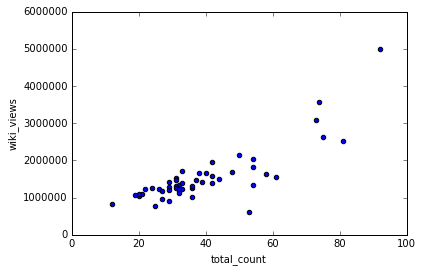

In [76]:
# Create plot again.
state_data.plot(x = 'total_count', y = 'wiki_views', kind = 'scatter');

In [77]:
# Check with a correlation matrix again.
state_data.ix[:,state_data.columns].corr()

,total_count,wiki_word_count,wiki_views
total_count,1.000000,0.358244,0.823737
wiki_word_count,0.358244,1.000000,0.350184
wiki_views,0.823737,0.350184,1.000000


The plot looks a little better, but the correlation matrix value relating wikipedia views and total_counts (0.821448) didn't get much better. 

It seems like Jeopardy may place more importance on the state of New York than wikipedia users. :) 

### Oklahoma is OK! Oklahoma City isn't confused with the state of Oklahoma.

Another state with a possibly confusing state capital is Oklahoma City, also the most populous city in the state. However, Oklahoma City doesn't have the same problems as New York City. Unlike New York where all of the questions where "city" is mentioned refer to New York City, for Oklahoma the questions where city is mentioned all refer to another city in the state of Oklahoma, rather than Oklahoma City.

In [38]:
# Here are the questions where Oklahoma is the answer and "city" is mentioned in the question.
df[(df['answer']=='Oklahoma') & (df['question'].str.contains('city'))]

,air_date,answer,category,question,round,show_number,value
115027,2010-09-21,Oklahoma,WOMEN ON THE MAP,"The city of Enid in this state is believed to be named for a character in ""Idylls of the King""",Jeopardy!,5982,800.0
127770,2010-11-15,Oklahoma,STATE FACTS,The city of Tahlequah in this state is the capital of the Cherokee Nation,Jeopardy!,6021,1000.0
